# Algoritmo K-Means y RFM-Scoring como estrategia combinada para la segmentación eficiente de clientes en el mercado minorista

**Resumen**

En este reporte se presenta una propuesta metodológica que combina el algoritmo **K-Means** en conjunto con un sistema de puntuación basado en las variables **recencia (R)**, **frecuencia (F)** y **valor monetario (M)** de los clientes de la empresa del mercado minorista **Cencosud S.A.** en su unidad de negocio ubicada en **Argentina**. En primer lugar,  presentamos el procedimiento desarrollado para adquirir los datos de **Amazon Web Services (AWS)** a través de consultas efectuadas con los sistemas de gestión de base de datos  `PostgreSQL` y `Redshift`. A continuación, detallamos el preprocesamiento de dichos datos mediante el lenguaje de programación Python y presentamos el diseño y la implementación del esquema de calificación **RFM** mostrando cómo a través de este sistema es posible valuar a los clientes según su comportamiento de compra. Seguidamente, tratamos someramente la aplicación del algoritmo de aprendizaje no supervidado K-Means para efectuar la segmentación de los clientes y una propuesta estadística innovadora para ponderar los puntajes en las tres direcciones individuales por cada cluster y explicamos cómo a partir de la comparación de los centroides de estos con el centroide global del conjunto de datos es posible categorizar a los clientes de manera efectiva. Por último, se presenta el detalle del procedimiento para poner a disposición la tabla final con los resultados obtenidos de cara a los distintos sectores que intervienen en el negocio.

**Palabras clave**: *RFM-Scoring, algoritmo K-Means, categorización, clusterización*.

# 1. Intoducción

La capacidad por comprender y segmentar clientes se ha convertido en un aspecto de importancia capital para el éxito corporativo. El advenimiento de la era digital ha propiciado una explosión de datos sin precedentes brindando una ventana de oportunidad única y superlativa para analizar la conducta de los consumidores y tomar decisiones informadas para mejorar la experiencia del cliente **[1, 2, 3, 4]**. Tomar ventaja de esta posibilidad conforma un desafío que puede ser abordado óptimamente mediante la implementación de algoritmos de aprendizaje estadístico (**SL**) en conjunto con los métodos asociados a la inteligencia de negocio (**BI**). En relación a esto, la introducción de un sistema de puntuación basado en el comportamiento de los compradores con el cual catalogarlos permite la construcción de estrategias comerciales y de marketing eficientes. Un sistema de puntos muy conocido se fundamenta en una metodología que evalúa el comportamiento del cliente en función de la recencia, frecuencia y valor monetario **[1, 2, 5, 6]**. Sin embargo, este sistema por sí solo adolece de ciertas debilidades, como el caso de la detección de patrones con el fin de agrupar a los clientes en grupos con comportamientos similares o la asignación de ponderaciones sobre los puntos asociados a las variables R,F y M que no estén sujetas al juicio humano sino a un protocolo estadístico robusto. En ese sentido, el uso de algoritmos no supervisados del aprendizaje estadístico pueden suplir las deficiencias que surgen naturalmente en **RFM** con lo que la combinación de ambos constituye una sinergia que bien utilizada puede generar valor agregado al negocio **[7, 8, 9, 10, 11]**. Por lo tanto, el objetivo de este proyecto es la de combinar el algoritmo **K-Means** y un sistema **RFM** para realizar una segmentación y categorización efectiva de los clientes en el sector del mercado minorista. La clusterización permitirá identificar grupos homogéneos de clientes con características similares, mientras que la puntuación **RFM** proporcionará una evaluación detallada de la recencia de las transacciones, la frecuencia de compra y el valor monetario asociado. La combinación de estas dos metodologías brindará una comprensión más profunda de los patrones de comportamiento del cliente, permitiendo así estrategias personalizadas de **marketing**, **retención** y **fidelización**. A lo largo de este reporte, se presentarán los fundamentos de la metodología utilizada en la implementación conjunta de **K-Means** y el sistema de puntuación desarrollado.

# 2. Roadmap del proyecto

**Paso 1: Preparación de Datos**
1. Construcción del dataset usando las definiciones de R, F, M a partir del armado de query en PostgreSql para extraer los        datos en AWS.
2. Limpieza y transformación de datos en Python (en concreto, realizar la normalización de RFM para obtener los scores            $S_R$, $S_F$, $S_M$).


**Paso 2: Implementación del algoritmo de clusterización K-means**
1. Ejecutar el algoritmo K-means para segmentar a los clientes en clústeres utilizando las librerías disponibles de ML en          Python.
2. Determinar el número óptimo de clústeres utilizando técnicas como el método del codo.

**Paso 3: Asignación de puntajes $S_{RFM}$ por clúster**

1. Para cada clúster obtenido con K-means, asignar puntajes $S_{RFM}$ a los clientes
2. Calcular las ponderaciones en las tres direcciones en el espacio de puntos interpretándolas como las varianzas explicadas por cluster.

**Paso 4: Inteligencia de negocio**

Diseñar nomenclatura específica para cada grupo basadas en su comportamiento RFM y las características únicas de cada clúster fijando de antemano los thresholds.

**Paso 5: Validación y Ajuste**

Informar las categorías a los sectores que usen el modelo para evaluar la aceptación, simpleza y efectividad de las mismas ajustando según sea necesario.

**Paso 6: Puesta en producción**

Migración a Amazon SageMaker: Adaptación del código - Prueba de escalado y experimentación.

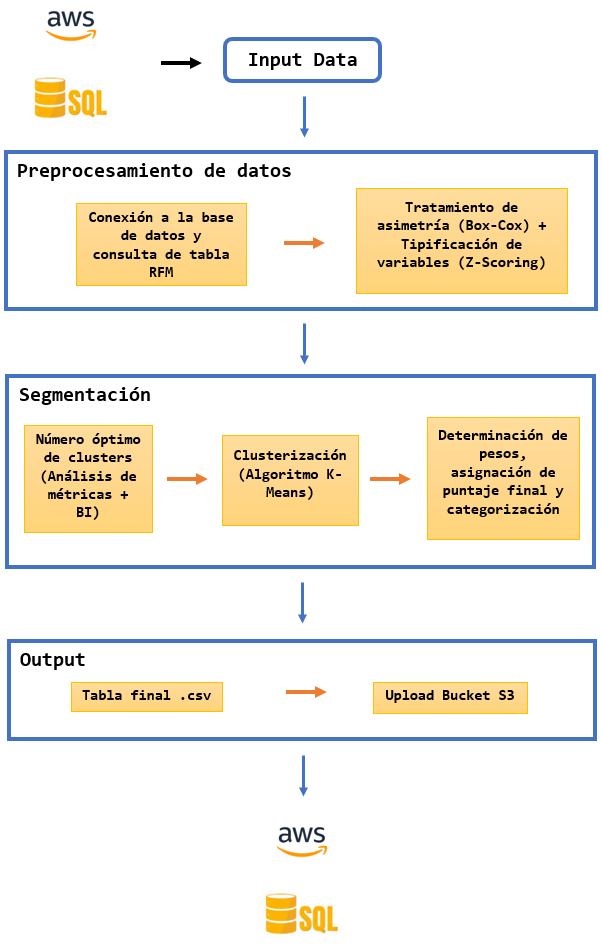

In [1]:
# Importar librería para visualizar imagen
from IPython.display import Image, display

# Ruta relativa de la imagen dentro del directorio de trabajo de SageMaker
image_path = 'flowchart.PNG'

# Muestra la imagen
display(Image(filename=image_path))

# 2. Dataset y Preprocesamiento

## 2.1. Importar las librerías

In [2]:
!pip install --upgrade numexpr
!pip install redshift_connector

In [3]:
# Módulos generales
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
# -------------------------------------
from scipy.stats import boxcox
from scipy.stats import skew

# Evitar sugerencias de código
import warnings
warnings.filterwarnings('ignore')

# Configurar Pandas para desplegar completamente el DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Módulos de aprendizaje estadístico
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Módulos ara efectuar la conexión a la base de datos
import redshift_connector
from sqlalchemy import create_engine
# Para subir a S3 los archivos .csv.
import sagemaker
import boto3
from io import StringIO

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2. Conexión a la base de datos y consulta de tabla RFM

In [5]:
conn = redshift_connector.connect(
     host = 'datalake-dw55-prod.ctnjyflrnhjv.us-east-1.redshift.amazonaws.com',
     database = 'arsuperlake_prod',
     port = 5439,
     user = 'rjkang',
     password = '#Rjkang2023'
  )

# Crear a el objeto cur
cur = conn.cursor()

In [6]:
# Modificar periodo y canal
period = 202405
flag = 'Vea'

# Query con parámetros
rfm_input_query = f"""SELECT *
                   FROM
                       lk_analytics.RFM_TOTAL_HISTORICO
                   WHERE 
                       periodo = {period}
                       AND cadena = '{flag}'"""

# Ejecutar la consulta con los parámetros
cur.execute(rfm_input_query)
# ------------------------------------------------------
# Obtener el DataFrame
input_data: pd.DataFrame = cur.fetch_dataframe()
# Hacer copia del Dataset
input_data_original = input_data.copy()

In [7]:
# Imprimir por pantalla las primeras líneas
input_data.head()

idcliente cadena  frecuencia    monto  recencia  periodo
0   15457550    Vea           2    36498        21   202405
1   14964280    Vea          14    85545        20   202405
2   14326038    Vea          16    99116         9   202405
3   14273833    Vea           1    13768        81   202405
4    8401207    Vea          66  1361696         2   202405

In [8]:
# Imprimir por pantalla las últimas líneas
input_data.tail()

idcliente cadena  frecuencia   monto  recencia  periodo
2239558   10021853    Vea           3   22815        13   202405
2239559   14682138    Vea           7   58326        29   202405
2239560   10888435    Vea          39  886655        31   202405
2239561    6892381    Vea           1   15775       272   202405
2239562   13144124    Vea           1   12078        90   202405

In [9]:
# Dimesión del DataFrame
input_data.shape

(2239563, 6)

In [10]:
# Tipos de datos
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239563 entries, 0 to 2239562
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   idcliente   int64 
 1   cadena      object
 2   frecuencia  int64 
 3   monto       int64 
 4   recencia    int64 
 5   periodo     int64 
dtypes: int64(5), object(1)
memory usage: 102.5+ MB


In [11]:
# Estadísticas básicas de los campos RFM
input_data[['recencia', 'frecuencia', 'monto']].describe()

recencia    frecuencia         monto
count  2.239563e+06  2.239563e+06  2.239563e+06
mean   7.883549e+01  1.526648e+01  2.091216e+05
std    9.051300e+01  2.698332e+01  4.607925e+05
min    0.000000e+00  1.000000e+00  0.000000e+00
25%    1.000000e+01  2.000000e+00  2.105400e+04
50%    4.000000e+01  6.000000e+00  7.472800e+04
75%    1.220000e+02  1.800000e+01  2.346680e+05
max    3.640000e+02  3.411000e+03  2.097502e+08

In [12]:
# Verificar si hay idcliente duplicados
duplicates = input_data['idcliente'].duplicated().any()

if duplicates:
    print("El DataFrame tiene idcliente duplicados.")
else:
    print("El DataFrame no tiene idcliente duplicados.")

El DataFrame no tiene idcliente duplicados.


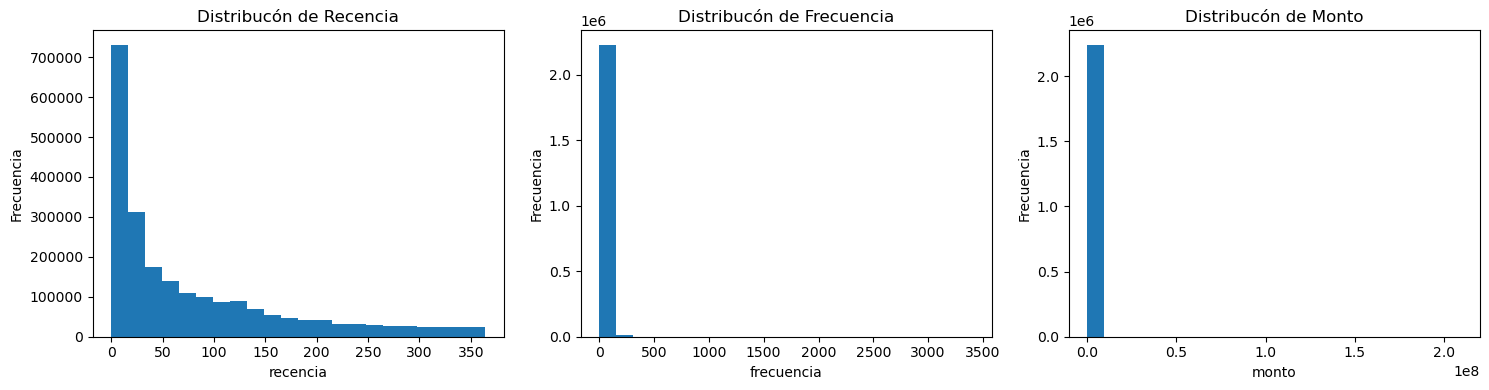

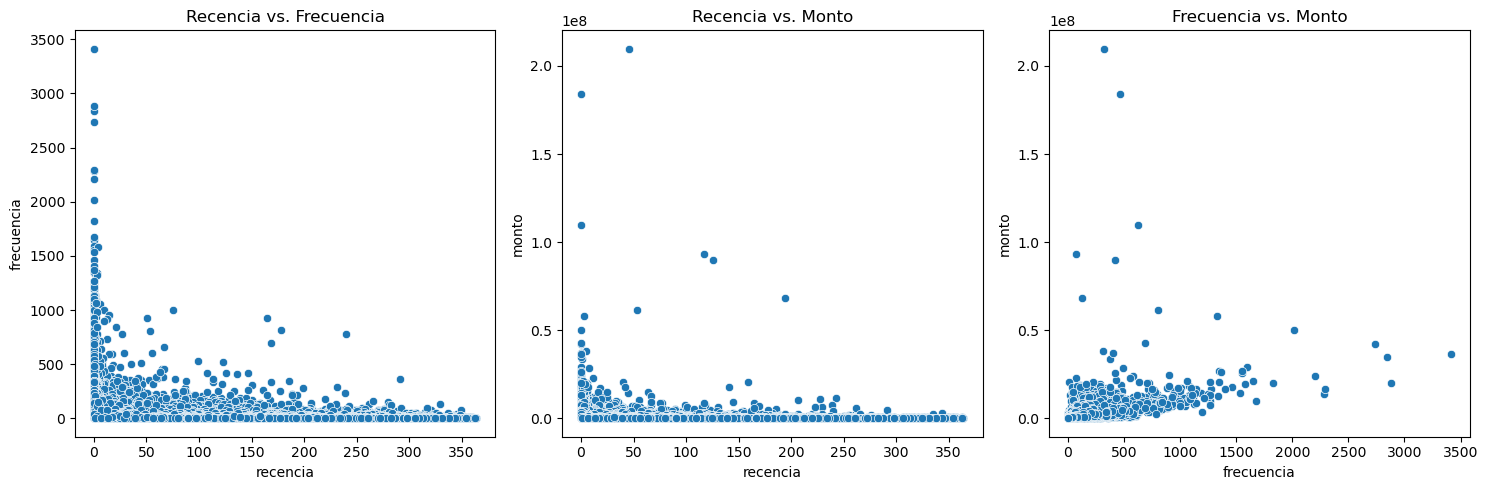

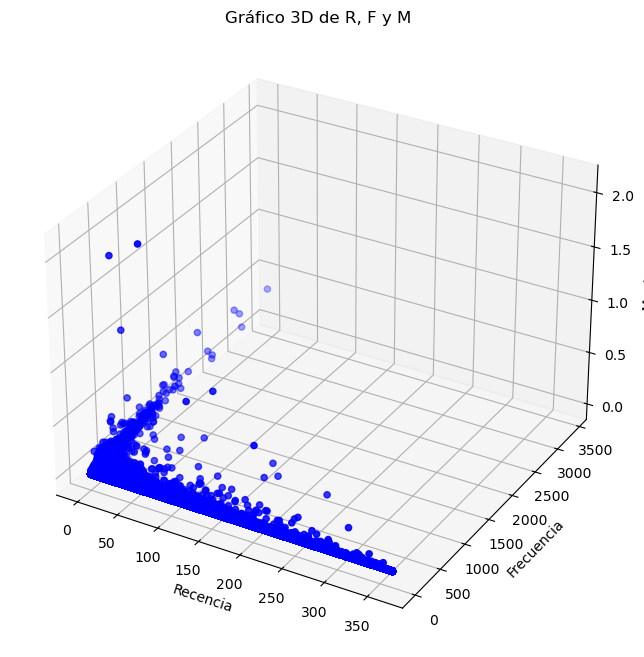

<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>
Asimetría - Media - Desviación Estándar
skew(R) = 1.3667
skew(F) 10.998
skew(M) 94.9062
---------------------------------------
mean(R) =  78.8355
mean(F) =  15.2665
mean(M) =  209121.6358
---------------------------------------
std(R) =  90.513
std(F) =  26.9833
std(M) =  460792.4652
<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>


In [13]:
# Gráficos RFM

# Regla de Sturges
number_bins = 1 + int(np.log2(len(input_data['recencia'])))

columns_to_visualize = ['recencia', 'frecuencia', 'monto']

# Histogramas
plt.figure(figsize=(15, 4))
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(1, len(columns_to_visualize), i)
    plt.hist(input_data[column], bins = number_bins)
    plt.title('Distribucón de ' + column.capitalize())
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot de R vs. F
plt.subplot(1, 3, 1)
sns.scatterplot(data=input_data, x='recencia', y='frecuencia')
plt.title('Recencia vs. Frecuencia')

# Scatter plot de R vs. M
plt.subplot(1, 3, 2)
sns.scatterplot(data=input_data, x='recencia', y='monto')
plt.title('Recencia vs. Monto')

# Scatter plot de F vs. M
plt.subplot(1, 3, 3)
sns.scatterplot(data=input_data, x='frecuencia', y='monto')
plt.title('Frecuencia vs. Monto')

plt.tight_layout()
plt.show()

# 3D plot

# Crear una figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Variables R, F y M
R = input_data['recencia']
F = input_data['frecuencia']
M = input_data['monto']

# Crear el gráfico 3D
ax.scatter(R, F, M, c='b', marker='o')

# Etiquetas de los ejes
ax.set_xlabel('Recencia')
ax.set_ylabel('Frecuencia')
ax.set_zlabel('Monto')

# Título del gráfico
plt.title('Gráfico 3D de R, F y M')

# Mostrar el gráfico
plt.show()

# Asimetría - Media - Desviación Estándar

print('<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>')
print('Asimetría - Media - Desviación Estándar')
print('=======================================')

print("skew(R) =", np.round(skew(input_data['recencia']),4))
print("skew(F)", np.round(skew(input_data['frecuencia']), 4))
print("skew(M)", np.round(skew(input_data['monto']), 4))

print('---------------------------------------')

print('mean(R) = ', np.round(input_data['recencia'].mean(), 4))
print('mean(F) = ', np.round(input_data['frecuencia'].mean(), 4))
print('mean(M) = ', np.round(input_data['monto'].mean(), 4))

print('---------------------------------------')
      
print('std(R) = ', np.round(input_data['recencia'].std(), 4))
print('std(F) = ', np.round(input_data['frecuencia'].std(), 4))
print('std(M) = ', np.round(input_data['monto'].std(), 4))

print('<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>')

# 3. Diseño e implementación de un sistema de puntuación basado en RFM

## 3.1. Estrategia para tratar el sesgo de las variables R, F y M

En orden a efectuar el proceso de clusterización implementando el algoritmo K-Means debemos tratar las datos para que se satisfagan los supuestos de no asimetría. Para abordar el sesgo en las variables de recencia (R), frecuencia (F) y valor monetario (M), se aplica la transformación de Box-Cox. La transformación Box-Cox conforman una familia de técnicas potenciales ampliamente empleadas en estadística. Estas transformaciones son utilizadas para mitigar el sesgo estadístico, contrarrestar varianzas desiguales en función de los valores de la variable predictora, y fundamentalmente, para mitigar la no linealidad en las relaciones entre variables, mejorando así la correlación entre ellas. Este enfoque lleva el nombre en honor a los estadísticos George E. P. Box y David Cox.

En nuestro proyecto, la transformación se realiza mediante la función boxcox de la biblioteca [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html). La fórmula de la transformación de Box-Cox está dada por:

$$
y(\lambda) = \left\{
  \begin{array}{ll}
    \frac{{x^\lambda - 1}}{{\lambda}}, & \text{si } \lambda \neq 0 \\
    \log(x), & \text{si } \lambda = 0
  \end{array}
\right.
$$

In [14]:
# Transformación Box-Cox

# Aplicar Box-Cox a 'recencia'
input_data['recencia'], LambdaRecencia = boxcox(input_data['recencia'] + 1)
# Aplicar Box-Cox a 'frecuencia'
input_data['frecuencia'], LambdaFrecuencia = boxcox(input_data['frecuencia'] + 1)
# Aplicar Box-Cox a 'monto'
input_data['monto'], LambdaMonto = boxcox(input_data['monto'] + 1)

input_data.head()

idcliente cadena  frecuencia      monto  recencia  periodo
0   15457550    Vea    0.973021  15.772808  4.074955   202405
1   14964280    Vea    2.026259  17.660051  3.996282   202405
2   14326038    Vea    2.093241  17.998326  2.822676   202405
3   14273833    Vea    0.641657  13.751608  6.580572   202405
4    8401207    Vea    2.715618  24.665458  1.208768   202405

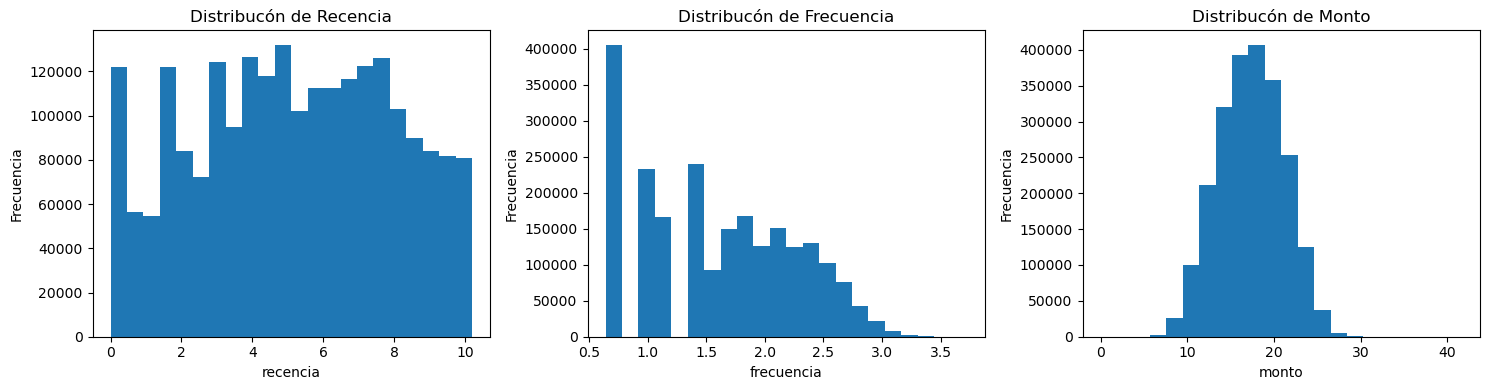

<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>
Asimetría - Media - Desviación Estándar
skew(R) = -0.0919
skew(F) 0.09
skew(M) -0.0193
---------------------------------------
mean(R) =  5.1505
mean(F) =  1.5941
mean(M) =  17.3221
---------------------------------------
std(R) =  2.7895
std(F) =  0.671
std(M) =  3.7416
<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>


In [15]:
# Gráficos RFM

# Regla de Sturges
number_bins = 1 + int(np.log2(len(input_data['recencia'])))

columns_to_visualize = ['recencia', 'frecuencia', 'monto']

# Histogramas

plt.figure(figsize=(15, 4))
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(1, len(columns_to_visualize), i)
    plt.hist(input_data[column], bins = number_bins)
    plt.title('Distribucón de ' + column.capitalize())
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Asimetría - Media - Desviación Estándar

print('<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>')
print('Asimetría - Media - Desviación Estándar')
print('=======================================')

print("skew(R) =", np.round(skew(input_data['recencia']), 4))
print("skew(F)", np.round(skew(input_data['frecuencia']), 4))
print("skew(M)", np.round(skew(input_data['monto']), 4))

print('---------------------------------------')

print('mean(R) = ', np.round(input_data['recencia'].mean(), 4))
print('mean(F) = ', np.round(input_data['frecuencia'].mean(), 4))
print('mean(M) = ', np.round(input_data['monto'].mean(), 4))

print('---------------------------------------')
      
print('std(R) = ', np.round(input_data['recencia'].std(), 4))
print('std(F) = ', np.round(input_data['frecuencia'].std(), 4))
print('std(M) = ', np.round(input_data['monto'].std(), 4))

print('<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>')

## 3.2.  Z-Scoring (tipificación de variables)

Debemos además efectuar la tipificación de las variables transformadas para asegurar que los datos estén estandarizados para el algoritmo K-Means, que utiliza la distancia euclidiana en su proceso de agrupamiento. Este preprocesamiento robustece la efectividad del modelo al garantizar que las variables sean comparables y contribuyan de manera equitativa a la formación de los clusters. La tipificación de las veriables se realiza de la siguiente manera:

$$
\left\{
\begin{array}{c}
S_R = \frac{R - \mu_R}{\sigma_R} \\
S_F = \frac{F - \mu_F}{\sigma_F} \\
S_M = \frac{M - \mu_M}{\sigma_M}
\end{array}
\right.
$$

In [16]:
# Tipificación para recencia
input_data['$S_R$'] = ((input_data['recencia'] - input_data['recencia'].mean()) / 
                       input_data['recencia'].std())

# Tipificación para frecuencia
input_data['$S_F$'] = ((input_data['frecuencia'] - input_data['frecuencia'].mean()) / 
                       input_data['frecuencia'].std())

# Tipificación para monto
input_data['$S_M$'] = ((input_data['monto'] - input_data['monto'].mean()) / 
                       input_data['monto'].std())

## 3.3. Métricas para la determinación del número óptimo de clusters

La determinación del número óptimo de clusters es un aspecto crucial en la implementación del algoritmo K-Means, ya que este constituye un hiperparámetro esencial del modelo. Para abordar este desafío, se adoptaron dos enfoques complementarios. En primer lugar, se recurrió al análisis de diversas medidas de validación externa, como la **inercia** (**mediante el método del codo**), **Calinski-Harabasz**, **Davies-Bouldin** y **Silueta**. El método del codo implica graficar la inercia en función del número de clusters y seleccionar el punto el punto en el que no hay cambio significativo en la inercia, lo que indica el número óptimo.

En segundo lugar, se empleó un enfoque heurístico que implica observar el número de categorías de clientes que el modelo identifica al iterar sobre distintos valores de clusters. Se descartaron valores de clusters que no generaban una segmentación significativa, es decir, cuando el incremento en el número de clusters no conducía a la formación de grupos adicionales y los centroides dentro de una misma categoría estaban visualmente próximos. Este análisis heurístico proporcionó una validación adicional para la selección del hiperparámetro, asegurando así una segmentación efectiva de los clientes en nuestro conjunto de datos RFM.

### 3.3.1. Inercia (método del codo)

La inercia, representada por la suma de las distancias al cuadrado entre cada punto y el centro de su cluster asignado, fue la primera métrica evaluada utilizando el método del codo. Este método consiste en graficar la inercia en función del número de clusters y buscar el "codo" en la curva, que indica el punto donde añadir más clusters ya no proporciona una mejora significativa en la reducción de la inercia.

In [17]:
# Extraer las columnas relevantes para el clustering
data = input_data[['$S_R$', '$S_F$', '$S_M$']]

# Inicializar lista para almacenar los resultados de la inercia
inertia_values = []

# Calcular la suma de los cuadrados de las distancias (inercia) para diferentes valores de k
for k in range(2, 11):  # Probamos con k desde 2 hasta 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    
    inertia = kmeans.inertia_
    inertia_values.append(inertia)

# Crear una figura para el Método del Codo
plt.figure(figsize=(8, 5))

# Método del codo
plt.plot(range(2, 11), inertia_values, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de Cuadrados de las Distancias (Inercia)')
plt.title('Método del Codo')
plt.grid(True)

plt.show()

### 3.3.2. Calinski Harabasz - Davies Bouldin - Silhouette

Adicionalmente, se consideraron métricas de validación interna de clusters, entre las que se incluyen **Calinski Harabasz**, **Davies Bouldin** y **Silhouette**. Para un estudio más pormenorizado de estos indicadores se puede analizar la referencia **[12]** y consultar la librería scikit-learn [[Calinski Harabasz](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), [Davies Bouldin](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html), [Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)].

Cabe destacar que debido a la cantidad enorme de registros en las tablas para calcular los indicadores se procedió a instanciar los datos tomando subconjuntos aleatorios y determinando de cada uno de ellos el número de cluster para el cual el indicador correspondiente fuera máximo o mínimo según corresponda.

In [18]:
# Inicializar listas para almacenar los resultados de los índices
cluster_numbers = list(range(2, 11))  # Números de clústeres de 2 a 10
instance_numbers = list(range(1, 11))  # Números de instancias de 1 a 10

# Definir el tamaño de cada muestra
sample_size = int(len(data)*0.0001)

# Calcular métricas de validación y la inercia para cada muestra
for instance in instance_numbers:
    max_ch = -1
    max_silhouette = -1
    min_db = float('inf')
    max_ch_cluster = -1
    max_silhouette_cluster = -1
    min_db_cluster = -1
    
    # Tomar una muestra aleatoria del conjunto de datos
    sample_indexes = np.random.choice(len(data), sample_size, replace=False)
    data_sample = data.iloc[sample_indexes]
    
    for k in cluster_numbers:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(data_sample)
        
        ch_metric = calinski_harabasz_score(data_sample, labels)
        db_metric = davies_bouldin_score(data_sample, labels)
        silhouette = silhouette_score(data_sample, labels)   
        
        # Actualizar máximos y mínimos
        if ch_metric > max_ch:
            max_ch = ch_metric
            max_ch_cluster = k
        if silhouette > max_silhouette:
            max_silhouette = silhouette
            max_silhouette_cluster = k
        if db_metric < min_db:
            min_db = db_metric
            min_db_cluster = k
    
    print(f'Instancia {instance}:')
    print('------------')
    print(f'Máximo Calinski-Harabasz: Optimal number of cluster = {max_ch_cluster}, Metric = {max_ch}')
    print(f'Máximo Silhouette: Optimal number of cluster = {max_silhouette_cluster}, Metric = {max_silhouette}')
    print(f'Mínimo Davies-Bouldin: Optimal number of cluster = {min_db_cluster}, Metric = {min_db}')

Instancia 1:
------------
Máximo Calinski-Harabasz: Optimal number of cluster = 2, Metric = 326.716559570208
Máximo Silhouette: Optimal number of cluster = 2, Metric = 0.474154591237793
Mínimo Davies-Bouldin: Optimal number of cluster = 2, Metric = 0.7618497605111552
Instancia 2:
------------
Máximo Calinski-Harabasz: Optimal number of cluster = 2, Metric = 292.43756933923333
Máximo Silhouette: Optimal number of cluster = 2, Metric = 0.4616845806266039
Mínimo Davies-Bouldin: Optimal number of cluster = 2, Metric = 0.7987421129383133
Instancia 3:
------------
Máximo Calinski-Harabasz: Optimal number of cluster = 2, Metric = 302.5537651858465
Máximo Silhouette: Optimal number of cluster = 2, Metric = 0.4636243174764794
Mínimo Davies-Bouldin: Optimal number of cluster = 2, Metric = 0.7773065747609051
Instancia 4:
------------
Máximo Calinski-Harabasz: Optimal number of cluster = 2, Metric = 329.47679425941874
Máximo Silhouette: Optimal number of cluster = 2, Metric = 0.4794051986239028
Mí

## 3.4. Proceso de clusterización

A continuación, se presenta en **pseudocódigo** el algoritmo K-Means utilizado para llevar a cabo la clusterización en este proyecto:

In [19]:
# Importar librería para visualizar imagen
from IPython.display import Image, display

# Ruta relativa de la imagen dentro del directorio de trabajo de SageMaker
image_path = 'kmeans_algorithm.PNG'

# Muestra la imagen
display(Image(filename=image_path))

In [20]:
# Definir el número óptimo de clústeres
optimal_cluster = 8 # dejar fijo en 8 dado que lo que importa para el negocio son las categorías no los clusters

# Aplicar K-Means
KMeans = KMeans(n_clusters=optimal_cluster, random_state=0)
cluster_labels = KMeans.fit_predict(data)

# Agregar los resultados del clustering al DataFrame original
input_data['cluster'] = cluster_labels

# Gráfico 3D: Recencia vs. Frecuencia vs. Monto
fig_3d = plt.figure(figsize=(8, 6))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Agregar scatter plot para cada cluster
for cluster in range(optimal_cluster):
    cluster_data = input_data[input_data['cluster'] == cluster]
    ax_3d.scatter(cluster_data['$S_R$'], cluster_data['$S_F$'], cluster_data['$S_M$'],
                  label=f'Cluster {cluster}', cmap='rainbow')

ax_3d.set_xlabel('$S_R$')
ax_3d.set_ylabel('$S_F$')
ax_3d.set_zlabel('$S_M$')
ax_3d.set_title('$S_R$ vs. $S_F$ vs. $S_M$')

# Fijar los ángulos de rotación
zen = 20  # Ángulo zenital en grados
azim = 45  # Ángulo azimutal en grados
ax_3d.view_init(elev=zen, azim=azim)

# Agregar leyenda
ax_3d.legend()

plt.tight_layout()
plt.show()

# Agregar gráficos de recencia vs. frecuencia, recencia vs. monto y frecuencia vs. monto

# Gráfico Recencia vs. Frecuencia
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(input_data['$S_R$'], input_data['$S_F$'], c=input_data['cluster'], cmap='rainbow')
plt.xlabel('$S_R$')
plt.ylabel('$S_F$')
plt.title('$S_R$ vs. $S_F$')

# Gráfico Recencia vs. Monto
plt.subplot(132)
plt.scatter(input_data['$S_R$'], input_data['$S_M$'], c=input_data['cluster'], cmap='rainbow')
plt.xlabel('$S_R$')
plt.ylabel('$S_M$')
plt.title('$S_R$ vs. $S_M$')

# Gráfico Frecuencia vs. Monto
plt.subplot(133)
plt.scatter(input_data['$S_F$'], input_data['$S_M$'], c=input_data['cluster'], cmap='rainbow')
plt.xlabel('$S_F$')
plt.ylabel('$S_M$')
plt.title('$S_R$ vs. $S_R$')

plt.tight_layout()
plt.show()

# Mostrar los clusters y su tamaño
cluster_sizes = input_data['cluster'].value_counts()
print(cluster_sizes)

cluster
0    339722
1    339142
6    317356
7    301720
3    254812
2    249438
5    241232
4    196141
Name: count, dtype: int64


## 3.5. Conformación del score RFM

El Score RFM final se calcula como una combinación ponderada de los scores individuales de Recencia ($S_R$), Frecuencia ($S_F$), y Monto ($S_M$). La fórmula del Score RFM ($S_{RFM}$) se expresa matemáticamente como:

$$
S_{RFM} = w_{S_R} \cdot S_R + w_{S_F} \cdot S_F + w_{S_M} \cdot S_M
$$

Aquí, $w_{S_R}$, $w_{S_F}$, $w_{S_M}$ son los pesos asignados a cada métrica, y están sujetos a la restricción:

$$
w_{S_R} + w_{S_F} + w_{S_M} = 1
$$

Estos pesos $(w_{S_R}, w_{S_F}, w_{S_M})$ se determinan utilizando las varianzas explicadas de cada métrica:

$$
\left\{
\begin{array}{c}
w_{S_R} = \frac{\sigma_{S_R}^2}{\sigma_{S_R}^2 + \sigma_{S_F}^2 + \sigma_{S_M}^2} \\
w_{S_F} = \frac{\sigma_{S_F}^2}{\sigma_{S_R}^2 + \sigma_{S_F}^2 + \sigma_{S_M}^2} \\
w_{S_M} = \frac{\sigma_{S_M}^2}{\sigma_{S_R}^2 + \sigma_{S_F}^2 + \sigma_{S_M}^2}
\end{array}
\right.
$$

Esta formulación permite una generalización a $N$ variables, lo que significa que el Score RFM ($S_{RFM}$) puede adaptarse para incorporar un conjunto más amplio de métricas ($S_i$). La ecuación general se define como:

$$
S_{RFM} = \sum_{i=1}^N w_{S_i} \cdot S_{i}
$$

donde $w_{S_i}$ representa los pesos asociados a cada métrica individual, y la restricción adicional es:

$$
\sum_{i=1}^N w_{S_i} = 1
$$

donde

$$
w_{S_i} = \frac{\sigma_{S_i}^2}{\sum_{i=1}^N\sigma_{S_i}^2}
$$

Este enfoque flexible permite una personalización efectiva del Score RFM según las necesidades específicas del análisis, permitiendo la inclusión de un número variable de métricas para mejorar o ajustar la categorización de los clientes.

La definición de los scores en cada dirección $(S_R, S_F, S_M)$ abre la posibilidad de efectuar una clasificación de los clusters resultantes, que puede resumirse en la tabla abajo detallada. Esta tabla proporciona un marco de referencia valioso para interpretar los perfiles de los clientes en cada categoría. Las flechas hacia arriba (↑) indican que la puntuación en la dirección correspondiente para ese tipo de cliente es mayor que el promedio total del conjunto de datos, mientras que las flechas hacia abajo (↓) señalan que la métrica es menor que el promedio total. Esta información es fundamental para la toma de decisiones estratégicas, ya que permite identificar patrones y tendencias específicas en el comportamiento de los clientes. Por ejemplo, los "**Clientes de mayor contribución**" se caracterizan por una Recencia ($\overline{S_R}$) inferior al promedio, pero con Frecuencia ($\overline{S_F}$) y Monto ($\overline{S_M}$) superiores al promedio, sugiriendo la importancia de mantener su compromiso con el negocio. Esta clasificación proporciona insights valiosos para diseñar estrategias personalizadas orientadas a la retención, desarrollo o captación de clientes, según sus perfiles particulares.


| Tipo de Cliente                      | $\overline{S_R}$  | $\overline{S_F}$  | $\overline{S_M}$  |
| -------------------------------------|-------------------|-------------------|-------------------|
| Clientes de mayor contribución       | $\downarrow$      | $\uparrow$        | $\uparrow$        |
| Clientes importantes a recordar      | $\uparrow$        | $\uparrow$        | $\uparrow$        |
| Clientes importantes para desarrollo | $\downarrow$      | $\downarrow$      | $\uparrow$        |
| Clientes importantes para retención  | $\uparrow$        | $\downarrow$      | $\uparrow$        |
| Clientes potenciales                 | $\downarrow$      | $\uparrow$        | $\downarrow$      |
| Clientes recientes                   | $\downarrow$      | $\downarrow$      | $\downarrow$      |
| Clientes de mantenimiento general    | $\uparrow$        | $\uparrow$        | $\downarrow$      |
| Clientes con baja actividad          | $\uparrow$        | $\downarrow$      | $\downarrow$      |

**Criterio de clasificación de clusters en donde $\uparrow$ significa mayor al promedio total mientras que $\downarrow$ significa menor al promedio total del dataset.**

In [21]:
# Variables R, F y M
variables = ['$S_R$', '$S_F$', '$S_M$']

# Lista para almacenar las varianzas por cada clúster (corrsponden a los pesos)
variances_by_cluster = []

# Iterar a través de cada clúster
for cluster in input_data['cluster'].unique():
    cluster_data = input_data[input_data['cluster'] == cluster][variables]
    cluster_variances = cluster_data.var()
    variances_by_cluster.append(cluster_variances)

# Crear un DataFrame con las varianzas por cada clúster
variance_df = pd.DataFrame(variances_by_cluster, index=input_data['cluster'].unique(), columns=variables)

# Normalizar las varianzas por clúster para que sumen 1
normalized_variances = variance_df.div(variance_df.sum(axis=1), axis=0)

var_r = input_data['$S_R$'].std()**2
var_f = input_data['$S_F$'].std()**2
var_m = input_data['$S_M$'].std()**2

# Imprimir las varianzas explicadas
print('<<<<<<<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>>>>>>')

print("Varianzas explicadas por cada clúster:")
print("--------------------------------------------------")
print(normalized_variances)
print("==================================================")
print("Varianzas Totales (como si fuesen un solo clúster)")
print("--------------------------------------------------")
print('VarNorm(R) = ', var_r/(var_r + var_f + var_m))
print('VarNorm(F) = ', var_f/(var_r + var_f + var_m))
print('VarNorm(M) = ', var_m/(var_r + var_f + var_m))
print('<<<<<<<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>>>>>>')

<<<<<<<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>>>>>>
Varianzas explicadas por cada clúster:
--------------------------------------------------
      $S_R$     $S_F$     $S_M$
4  0.392278  0.243477  0.364245
3  0.399898  0.312353  0.287750
5  0.341841  0.342682  0.315478
1  0.290101  0.400947  0.308952
2  0.405047  0.240170  0.354783
6  0.322273  0.312347  0.365381
7  0.378457  0.147689  0.473854
0  0.311478  0.343318  0.345205
Varianzas Totales (como si fuesen un solo clúster)
--------------------------------------------------
VarNorm(R) =  0.33333333333463955
VarNorm(F) =  0.33333333333259185
VarNorm(M) =  0.3333333333327686
<<<<<<<<<<<<<<<<<<<<<<<< * >>>>>>>>>>>>>>>>>>>>>>>


In [22]:
# Agregar los resultados del clustering al DataFrame original
input_data['cluster'] = cluster_labels

# Agregar los pesos
for cluster in input_data['cluster'].unique():
    mask = input_data['cluster'] == cluster
    # Agregar las columnas de pesos a cada cliente en el clúster
    input_data.loc[mask, '$\omega_R$'] = normalized_variances.loc[cluster, '$S_R$']
    input_data.loc[mask, '$\omega_F$'] = normalized_variances.loc[cluster, '$S_F$']
    input_data.loc[mask, '$\omega_M$'] = normalized_variances.loc[cluster, '$S_M$']


# Insertar las columnas originales al comienzo del DataFrame
input_data.insert(1, 'R', input_data_original['recencia'])
input_data.insert(2, 'F', input_data_original['frecuencia'])
input_data.insert(3, 'M', input_data_original['monto'])
input_data.insert(4, 'Cadena', input_data_original['cadena'])
    
# Agregar la columna S_{RFM} al DataFrame
input_data['$S_{RFM}$'] = 0.0
for cluster in input_data['cluster'].unique():
    mask = input_data['cluster'] == cluster
    input_data.loc[mask, '$S_{RFM}$'] = (
        - input_data.loc[mask, '$S_R$'] * input_data.loc[mask, '$\omega_R$'] +
          input_data.loc[mask, '$S_F$'] * input_data.loc[mask, '$\omega_F$'] +
          input_data.loc[mask, '$S_M$'] * input_data.loc[mask, '$\omega_M$']
    )

columns_order = ['idcliente', 'R', 'F', 'M', 'cadena', 'cluster', 
                 '$\omega_R$', '$\omega_F$', '$\omega_M$',
                 '$S_R$', '$S_F$', '$S_M$', '$S_{RFM}$']

# Reordenar las columnas en el DataFrame
input_data = input_data.reindex(columns=columns_order)

# Imprimir el DataFrame
input_data.head()

idcliente   R   F        M cadena  cluster  $\omega_R$  $\omega_F$  \
0   15457550  21   2    36498    Vea        4    0.392278    0.243477   
1   14964280  20  14    85545    Vea        3    0.399898    0.312353   
2   14326038   9  16    99116    Vea        5    0.341841    0.342682   
3   14273833  81   1    13768    Vea        1    0.290101    0.400947   
4    8401207   2  66  1361696    Vea        2    0.405047    0.240170   

   $\omega_M$     $S_R$     $S_F$     $S_M$  $S_{RFM}$  
0    0.364245 -0.385552 -0.925604 -0.414076  -0.224945  
1    0.287750 -0.413755  0.644007  0.090313   0.392604  
2    0.315478 -0.834473  0.743829  0.180721   0.597166  
3    0.308952  0.512671 -1.419427 -0.954267  -1.012664  
4    0.354783 -1.413032  1.671339  1.962595   1.670045

In [23]:
# Calcular los valores medios de S_R, S_F y S_M por cluster
means_by_cluster = input_data.groupby('cluster').agg({'$S_R$':'mean', '$S_F$':'mean', '$S_M$':'mean'})

# Calcular las medias totales de S_R, S_F y S_M
MeanSr = input_data['$S_R$'].mean()
MeanSf = input_data['$S_F$'].mean()
MeanSm = input_data['$S_M$'].mean()

# Definir una función para asignar la categoría
def assign_category(row):
    """
    Asigna una categoría a un cliente basado en sus valores de RFM y las medias del clúster y totales.
    
    Args:
        row (pd.Series): Fila del DataFrame con los valores de RFM y el clúster asignado.
        
    Returns:
        str: Categoría asignada al cliente.
    """
    ClusterMeans = means_by_cluster.loc[row['cluster']]  # Obtener las medias del clúster correspondiente
    if (ClusterMeans['$S_R$'] < MeanSr and 
        ClusterMeans['$S_F$'] > MeanSf and 
        ClusterMeans['$S_M$'] > MeanSm):
        return 'clientes de mayor contribucion'
    elif (ClusterMeans['$S_R$'] > MeanSr and 
          ClusterMeans['$S_F$'] > MeanSf and 
          ClusterMeans['$S_M$'] > MeanSm):
        return 'clientes importantes a recordar'
    elif (ClusterMeans['$S_R$'] < MeanSr and 
          ClusterMeans['$S_F$'] < MeanSf and 
          ClusterMeans['$S_M$'] > MeanSm):
        return 'clientes importantes para desarrollo'
    elif (ClusterMeans['$S_R$'] > MeanSr and 
          ClusterMeans['$S_F$'] < MeanSf and 
          ClusterMeans['$S_M$'] > MeanSm):
        return 'clientes importantes para retencion'
    elif (ClusterMeans['$S_R$'] < MeanSr and 
          ClusterMeans['$S_F$'] > MeanSf and 
          ClusterMeans['$S_M$'] < MeanSm):
        return 'clientes potenciales'
    elif (ClusterMeans['$S_R$'] < MeanSr and 
          ClusterMeans['$S_F$'] < MeanSf and 
          ClusterMeans['$S_M$'] < MeanSm):
        return 'clientes recientes'
    elif (ClusterMeans['$S_R$'] > MeanSr and 
          ClusterMeans['$S_F$'] > MeanSf and 
          ClusterMeans['$S_M$'] < MeanSm):
        return 'clientes de mantenimiento general'
    elif (ClusterMeans['$S_R$'] > MeanSr and 
          ClusterMeans['$S_F$'] < MeanSf and 
          ClusterMeans['$S_M$'] < MeanSm):
        return 'clientes con baja actividad'

# Aplicar la función para asignar la categoría
input_data['categoria'] = input_data.apply(assign_category, axis=1)

In [24]:
# Función para asignar valores a la columna 'descripcion'
def asignar_descripcion(categoria):
    """
    Asigna una descripción basada en la categoría proporcionada.

    Parameters:
    - categoria (str): La categoría para la cual se asignará la descripción.

    Returns:
    - str: La descripción asignada basada en la categoría.
    """
    
    if categoria == 'clientes de mayor contribucion':
        return 'r ↓ f ↑ m ↑'
    elif categoria == 'clientes importantes a recordar':
        return 'r ↑ f ↑ m ↑'
    elif categoria == 'clientes importantes para desarrollo':
        return 'r ↓ f ↓ m ↑'
    elif categoria == 'clientes importantes para retencion':
        return 'r ↑ f ↓ m ↑'
    elif categoria == 'clientes potenciales':
        return 'r ↓ f ↑ m ↓'
    elif categoria == 'clientes recientes':
        return 'r ↓ f ↓ m ↓'
    elif categoria == 'clientes de mantenimiento general':
        return 'r ↑ f ↑ m ↓'
    elif categoria == 'clientes con baja actividad':
        return 'r ↑ f ↓ m ↓'
    else:
        return ''  # Manejar categorías no especificadas

# Aplicar la función a la columna 'categoría' para crear la nueva columna 'descripcion'
input_data['descripcion'] = input_data['categoria'].apply(asignar_descripcion)

In [25]:
# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar la columna $S_{RFM}$
input_data['$S_{RFM}^{Norm}$'] = scaler.fit_transform(input_data[['$S_{RFM}$']])

# Imprimir el DataFrame
input_data.head()

idcliente   R   F        M cadena  cluster  $\omega_R$  $\omega_F$  \
0   15457550  21   2    36498    Vea        4    0.392278    0.243477   
1   14964280  20  14    85545    Vea        3    0.399898    0.312353   
2   14326038   9  16    99116    Vea        5    0.341841    0.342682   
3   14273833  81   1    13768    Vea        1    0.290101    0.400947   
4    8401207   2  66  1361696    Vea        2    0.405047    0.240170   

   $\omega_M$     $S_R$     $S_F$     $S_M$  $S_{RFM}$  \
0    0.364245 -0.385552 -0.925604 -0.414076  -0.224945   
1    0.287750 -0.413755  0.644007  0.090313   0.392604   
2    0.315478 -0.834473  0.743829  0.180721   0.597166   
3    0.308952  0.512671 -1.419427 -0.954267  -1.012664   
4    0.354783 -1.413032  1.671339  1.962595   1.670045   

                        categoria  descripcion  $S_{RFM}^{Norm}$  
0              clientes recientes  r ↓ f ↓ m ↓          0.424524  
1              clientes recientes  r ↓ f ↓ m ↓          0.516822  
2  clientes de mayor contribucion  r ↓ f ↑ m ↑          0.547395  
3     clientes con baja actividad  r ↑ f ↓ m ↓          0.306792  
4  clientes de mayor contribucion  r ↓ f ↑ m ↑          0.707746

## 3.6. Análisis de la puntuación

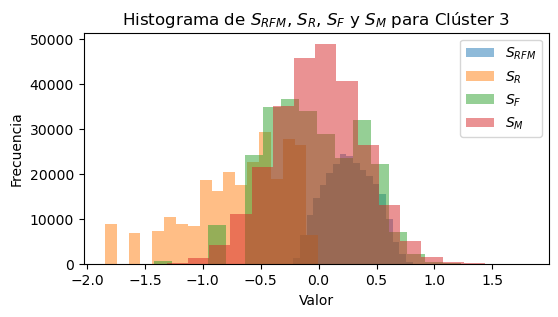

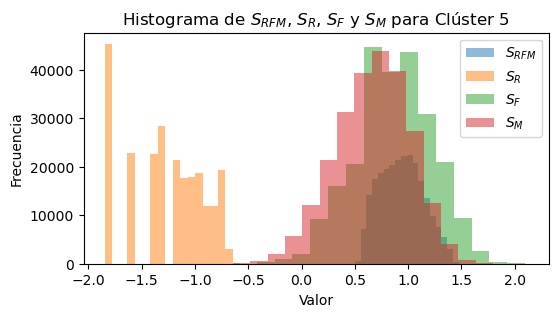

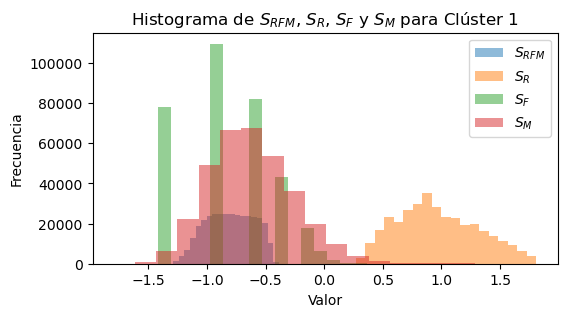

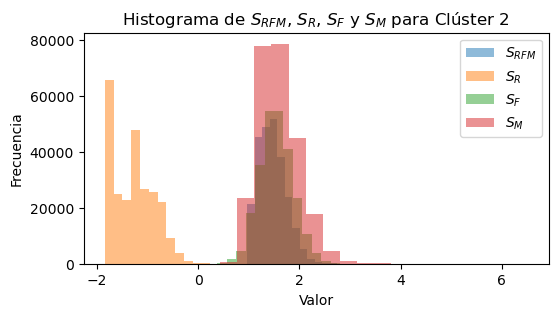

In [26]:
# Distribución de Scores RFM

# Crear un histograma de Scoring normalizado para cada clúster
for cluster in input_data['cluster'].unique():
    # Filtrar el DataFrame por clúster
    cluster_data = input_data[input_data['cluster'] == cluster]
    number_bins = 1 + int(np.log2(len(input_data[input_data['cluster'] == cluster])))
    # Crear el histograma
    plt.figure(figsize=(6, 3))
    plt.hist(cluster_data['$S_{RFM}$'], bins=number_bins, alpha=0.5, label='$S_{RFM}$')
    plt.hist(cluster_data['$S_R$'], bins=number_bins, alpha=0.5, label='$S_R$')
    plt.hist(cluster_data['$S_F$'], bins=number_bins, alpha=0.5, label='$S_F$')
    plt.hist(cluster_data['$S_M$'], bins=number_bins, alpha=0.5, label='$S_M$')
    
    # Personalizar el título y las etiquetas de los ejes
    plt.title(f'Histograma de $S_{{RFM}}$, $S_R$, $S_F$ y $S_M$ para Clúster {cluster}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.legend(loc='upper right')
    
    # Mostrar el histograma
    plt.show()

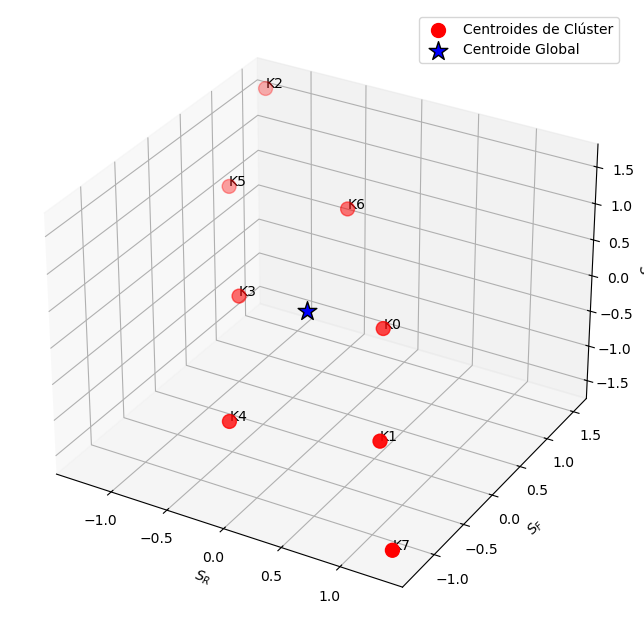

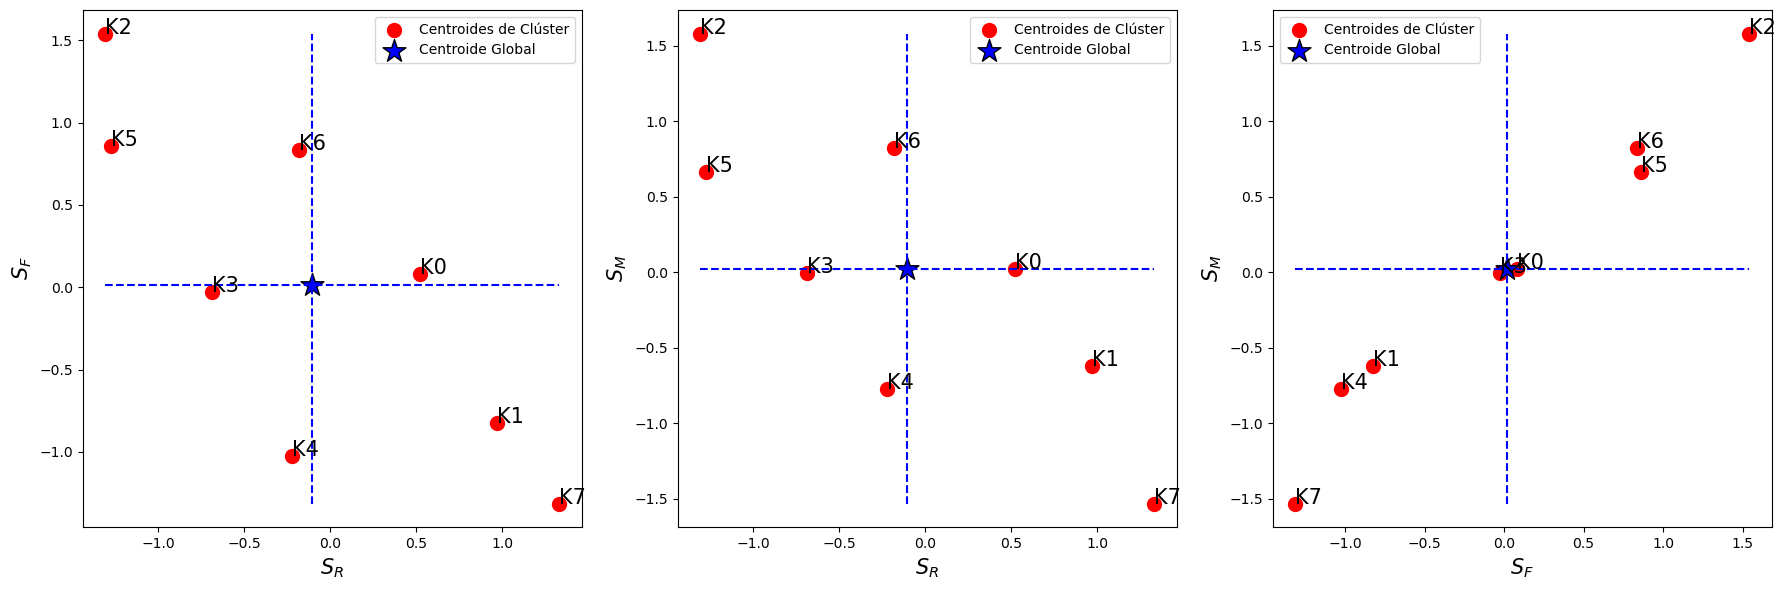

In [27]:
# Centroides en el espacio de puntos

# Agrupar por clúster
clustered_data = input_data[['$S_R$', '$S_F$', '$S_M$', 'cluster']].groupby('cluster').mean()

# Calcular el centroide global
global_centroid = clustered_data.mean()

# Ajustar el tamaño de los puntos y el fontsize de las etiquetas de los ejes
point_size = 100
fontsize = 15

# Gráfico 3D

# Crear la figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extraer las coordenadas de los centroides
x, y, z = clustered_data['$S_R$'], clustered_data['$S_F$'], clustered_data['$S_M$']
ax.scatter(x, y, z, c='r', s=point_size, marker='o', label='Centroides de Clúster')

# Añadir el centroide global
ax.scatter(global_centroid['$S_R$'], global_centroid['$S_F$'], global_centroid['$S_M$'],
           c='b', s=200, marker='*', label='Centroide Global', edgecolors='k')

# Configurar etiquetas de los ejes
ax.set_xlabel('$S_R$')
ax.set_ylabel('$S_F$')
ax.set_zlabel('$S_M$')

# Agregar etiquetas a los puntos
for i, txt in enumerate(clustered_data.index):
    ax.text(x[i], y[i], z[i], f'K{txt}')

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# Proyecciones

# Crear la figura con subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Proyección XY
ax_xy = axes[0]
x, y = clustered_data['$S_R$'], clustered_data['$S_F$']
ax_xy.scatter(x, y, c='r', s=point_size, marker='o', label='Centroides de Clúster')
ax_xy.scatter(global_centroid['$S_R$'], global_centroid['$S_F$'], c='b', s=300, marker='*', 
              label='Centroide Global', edgecolors='k')
ax_xy.set_xlabel('$S_R$', fontsize=fontsize)
ax_xy.set_ylabel('$S_F$', fontsize=fontsize)
for i, txt in enumerate(clustered_data.index):
    ax_xy.text(x[i], y[i], f'K{txt}', fontsize=fontsize)
ax_xy.hlines(global_centroid['$S_F$'], min(x), max(x), colors='b', linestyles='dashed')
ax_xy.vlines(global_centroid['$S_R$'], min(y), max(y), colors='b', linestyles='dashed')
ax_xy.legend()

# Proyección XZ
ax_xz = axes[1]
x, z = clustered_data['$S_R$'], clustered_data['$S_M$']
ax_xz.scatter(x, z, c='r', s=point_size, marker='o', label='Centroides de Clúster')
ax_xz.scatter(global_centroid['$S_R$'], global_centroid['$S_M$'], c='b', s=300, marker='*', 
              label='Centroide Global', edgecolors='k')
ax_xz.set_xlabel('$S_R$', fontsize=fontsize)
ax_xz.set_ylabel('$S_M$', fontsize=fontsize)
for i, txt in enumerate(clustered_data.index):
    ax_xz.text(x[i], z[i], f'K{txt}', fontsize=fontsize)
ax_xz.hlines(global_centroid['$S_M$'], min(x), max(x), colors='b', linestyles='dashed')
ax_xz.vlines(global_centroid['$S_R$'], min(z), max(z), colors='b', linestyles='dashed')
ax_xz.legend()

# Proyección YZ
ax_yz = axes[2]
y, z = clustered_data['$S_F$'], clustered_data['$S_M$']
ax_yz.scatter(y, z, c='r', s=point_size, marker='o', label='Centroides de Clúster')
ax_yz.scatter(global_centroid['$S_F$'], global_centroid['$S_M$'], c='b', s=300, marker='*', 
              label='Centroide Global', edgecolors='k')
ax_yz.set_xlabel('$S_F$', fontsize=fontsize)
ax_yz.set_ylabel('$S_M$', fontsize=fontsize)
for i, txt in enumerate(clustered_data.index):
    ax_yz.text(y[i], z[i], f'K{txt}', fontsize=fontsize)
ax_yz.hlines(global_centroid['$S_M$'], min(y), max(y), colors='b', linestyles='dashed')
ax_yz.vlines(global_centroid['$S_F$'], min(z), max(z), colors='b', linestyles='dashed')
ax_yz.legend()

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

## 3.7. Upload tabla final a la base de datos

In [28]:
# Copiar Dataframe original
input_data_copy= input_data_original.copy()

# Extraer columna y cambiar nombre
input_data['periodo'] = input_data_copy['periodo']

# Reordenar las columnas
input_data = input_data[['periodo', 'idcliente', 'cadena',
                         'R', 'F', 'M', 'categoria', '$S_{RFM}^{Norm}$',
                         'descripcion']]

input_data = input_data.rename(columns={'$S_{RFM}^{Norm}$': 'S_RFM'})

# Imprimir primeras filas
input_data.head()

periodo  idcliente cadena   R   F        M                       categoria  \
0   202405   15457550    Vea  21   2    36498              clientes recientes   
1   202405   14964280    Vea  20  14    85545              clientes recientes   
2   202405   14326038    Vea   9  16    99116  clientes de mayor contribucion   
3   202405   14273833    Vea  81   1    13768     clientes con baja actividad   
4   202405    8401207    Vea   2  66  1361696  clientes de mayor contribucion   

      S_RFM  descripcion  
0  0.424524  r ↓ f ↓ m ↓  
1  0.516822  r ↓ f ↓ m ↓  
2  0.547395  r ↓ f ↑ m ↑  
3  0.306792  r ↑ f ↓ m ↓  
4  0.707746  r ↓ f ↑ m ↑

In [29]:
# Categorías distintas
registros_distintos = input_data['categoria'].unique()

print("Cantidad de categorias únicas = ", len(registros_distintos))
print("-----------------------------")
for i in range(len(registros_distintos)):
    print(registros_distintos[i])

Cantidad de categorias únicas =  4
-----------------------------
clientes recientes
clientes de mayor contribucion
clientes con baja actividad
clientes importantes a recordar


In [30]:
# Nombre del archivo
file_name = f'ResultadosRfmOmnicanal{flag}{period}.csv'

# Guardar DataFrame como CSV
input_data.to_csv(file_name, index=False)

# Subir el archivo CSV a Amazon S3
bucket_name = 'cencosud.prod.super.ar.raw'  # Reemplazar con el nombre del bucket
s3_path = f'crm/Kang/RfmOutcomes/{file_name}'

# Obtener el rol de SageMaker predeterminado
role = sagemaker.get_execution_role()

# Crear cliente de S3 sin necesidad de especificar credenciales
s3_client = boto3.client('s3')

# Subir el archivo al bucket de S3
s3_client.upload_file(file_name, bucket_name, s3_path)

print(f'Archivo {file_name} subido a S3 en la ruta {s3_path}')

Archivo ResultadosRfmOmnicanalVea202405.csv subido a S3 en la ruta crm/Kang/RfmOutcomes/ResultadosRfmOmnicanalVea202405.csv


In [31]:
# Configuración de la conexión a Redshift
redshift_config = {
    'host': 'datalake-dw55-prod.ctnjyflrnhjv.us-east-1.redshift.amazonaws.com',
    'database': 'arsuperlake_prod',
    'port': 5439,
    'user': 'rjkang',
    'password': '#Rjkang2023'
}

# Establecer la conexión a Redshift
conn = redshift_connector.connect(**redshift_config)

# Crear el objeto cursor
cur = conn.cursor()

# Definir la ruta del archivo en S3
s3_path = f"s3://cencosud.prod.super.ar.raw/crm/Kang/RfmOutcomes/ResultadosRfmOmnicanal{flag}{period}.csv"

# Nombre de la tabla en Redshift
table_name = "Resultados_Rfm_Omnicanal"

# Crear el comando COPY
copy_query = f""" COPY lk_analytics.{table_name}
                  FROM '{s3_path}'
                  IAM_ROLE 'arn:aws:iam::191690883584:role/datalake-dw55-prod-redshift-service-role'
                  CSV
                  IGNOREHEADER 1
                  DELIMITER ',';"""

# Ejecutar el comando COPY
cur.execute(copy_query)

# Hacer commit para aplicar los cambios
conn.commit()

# Cerrar el cursor y la conexión
cur.close()
conn.close()

print(f'Carga de datos desde S3 a Redshift completada para la tabla {table_name}')

Carga de datos desde S3 a Redshift completada para la tabla Resultados_Rfm_Omnicanal


# 5. Referencias

**[1]** Yulu He and Yanxia Cheng. Customer segmentation and management of online shops based on rfm model. In Application of Intelligent Systems in Multi-modal Information Analytics: Proceedings of the 2020 International Conference on Multi-model Information Analytics (MMIA2020), Volume 1, pages 34–41. Springer, 2021.

**[2]** Konstantinos K Tsiptsis and Antonios Chorianopoulos. Data mining techniques in CRM: inside
customer segmentation. John Wiley & Sons, 2011.

**[3]** Mussadiq Abdul Rahim, Muhammad Mushafiq, Salabat Khan, and Zulfiqar Ali Arain. Rfm-based repurchase behavior for customer classification and segmentation. Journal of Retailing and Consumer Services, 61:102566, 2021.

**[4]** Mohammadreza Tavakoli, Mohammadreza Molavi, Vahid Masoumi, Majid Mobini, Sadegh Etemad, and Rouhollah Rahmani. Customer segmentation and strategy development based on user behavior analysis, rfm model and data mining techniques: a case study. In 2018 IEEE 15th International Conference on e-Business Engineering (ICEBE), pages 119–126. IEEE, 2018.

**[5]** Jo-Ting Wei, Shih-Yen Lin, and Hsin-Hung Wu. A review of the application of rfm model. African Journal of Business Management, 4(19):4199, 2010.

**[6]** Derya Birant. Data mining using rfm analysis. In Knowledge-oriented applications in data mining. IntechOpen, 2011.

**[7]** Palaksha Anitha and Malini M Patil. Rfm model for customer purchase behavior using k-means algorithm. Journal of King Saud University-Computer and Information Sciences, 34(5):1785–1792, 2022.

**[8]** Rajan Vohra, Jankisharan Pahareeya, Abir Hussain, Fawaz Ghali, and Alison Lui. Using self organizing maps and k means clustering based on rfm model for customer segmentation in the online retail business. In Intelligent Computing Methodologies: 16th International Conference, ICIC 2020, Bari, Italy, October 2–5, 2020, Proceedings, Part III 16, pages 484–497. Springer, 2020.

**[9]** RW Sembiring Brahmana, Fahd Agodzo Mohammed, and K Chairuang. Customer segmentation based on rfm model using k-means, k-medoids, and dbscan methods. Lontar Komput. J. Ilm. Teknol. Inf, 11(1):32, 2020.

**[10]** Jun Wu, Li Shi, Wen-Pin Lin, Sang-Bing Tsai, Yuanyuan Li, Liping Yang, and Guangshu Xu. An empirical study on customer segmentation by purchase behaviors using a rfm model and k-means algorithm. Mathematical Problems in Engineering, 2020:1–7, 2020.

**[11]** Anu Gupta Aggarwal and Sweta Yadav. Customer segmentation using fuzzy-ahp and rfm model. In 2020 8th International Conference on Reliability, Infocom Technologies and Optimization (Trends and Future Directions)(ICRITO), pages 77–80. IEEE, 2020.

**[12]** Yanchi Liu, Zhongmou Li, Hui Xiong, Xuedong Gao, and Junjie Wu. Understanding of internal clustering validation measures. In 2010 IEEE international conference on data mining, pages 911–916. IEEE, 2010